# 1. Dataset

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

import random
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from torch.utils.data import DataLoader, TensorDataset
from scipy.cluster.hierarchy import dendrogram, linkage
from torch.distributions.categorical import Categorical
from transformers import BertTokenizer, BertForMaskedLM, AdamW, BertForSequenceClassification, BertModel, BertConfig

In [2]:
def sentenceToTensor(tokens_list):
    # Convert list of strings to tensor of token indices (integers)
    #
    # Input
    #  tokens_list : list of strings, e.g. ['<SOS>','lion','eat','man','<EOS>']
    # Output
    #  1D tensor of the same length (integers), e.g., tensor([ 2, 18, 13, 19,  0])
    assert (isinstance(tokens_list, list))
    tokens_index = [token_to_index[token] for token in tokens_list]
    return torch.tensor(tokens_index)

In [3]:
# load and process the set of simple sentences
with open('new_sentences.txt','r') as fid:
    lines = fid.readlines()
sentences_str = [l.strip() for l in lines][:1000]
sentences_tokens = [s.split() for s in sentences_str]
sentences_tokens = [['<SOS>']+s+['<EOS>'] for s in sentences_tokens]
unique_tokens = sorted(set(sum(sentences_tokens,[])))
n_tokens = len(unique_tokens) # all words and special tokens
token_to_index = {t : i for i,t in enumerate(unique_tokens)}
index_to_token = {i : t for i,t in enumerate(unique_tokens)}
training_pats = [sentenceToTensor(s) for s in sentences_tokens] # python list of 1D sentence tensors
ntrain = len(training_pats)
print('mapping unique tokens to integers: %s \n' % token_to_index)
print('example sentence as string: %s \n' % ' '.join(sentences_tokens[0]))
print('example sentence as tensor: %s \n' % training_pats[0])

mapping unique tokens to integers: {'<EOS>': 0, '<SOS>': 1, 'book': 2, 'boy': 3, 'bread': 4, 'break': 5, 'car': 6, 'cat': 7, 'chase': 8, 'cookie': 9, 'dog': 10, 'dragon': 11, 'eat': 12, 'exist': 13, 'girl': 14, 'glass': 15, 'like': 16, 'lion': 17, 'man': 18, 'monster': 19, 'mouse': 20, 'move': 21, 'plate': 22, 'rock': 23, 'sandwich': 24, 'see': 25, 'sleep': 26, 'smell': 27, 'think': 28, 'woman': 29} 

example sentence as string: <SOS> mouse see glass <EOS> 

example sentence as tensor: tensor([ 1, 20, 25, 15,  0]) 



### Simple Recurrent Network

- **Input embedding**. In Elman's original model, each word was represented by
  a fixed one-hot input vector. Instead, here we will learn a continuous
  embedding vector (size `hidden_size=20`) to represent each input word. These
  vectors are learnable parameters. When a word is provided as input to the
  SRN, it is converted to the corresponding input embedding. This layer is
  setup for you already in the started class,
  `self.embed = nn.Embedding(vocab_size,hidden_size)`
- **Hidden layer**. This layer has length `hidden_size` and uses the
  **logistic** activation function. The initial vector $h_{-1}$ should be all
  zeros.
- **Output layer**. This layer has length `vocab_size` and uses the
  **softmax** activation function. Thus, the SRN will represent an explicit
  probability distribution over the next token $w_j$ given the past tokens
  $w_1,\dots,w_{j-1}$, through the equation $P(w_j | w_1,\dots,w_{j-1})$
- **Loss**. The SRN will train to maximize the log-likelihood of the target
  output words, e.g., we use the negative log-likelihood loss `nn.NLLLoss`. If
  passed a tensor representing multiple target predictions, this loss takes
  the mean across predictions.
- **Optimizer**. We found reasonable results with the `AdamW` optimizer with
  weight decay of 0.04. Adam is like stochastic gradient descent but adapts
  the learning rate for each parameter based on the variance of the gradient.
  Weight decay encourages the parameters to be close to zero leading to more
  stable input embeddings.
- **Batching**. We suggest _no batching_ for this simple code. Thus, the
  optimizer takes a step after each individual sentence. The `forward` method
  should process only one input word at a time. Batching produces much faster
  code and is recommended in practice, but it's not required here. If you want
  to rewrite the code to process multiple timesteps and sentences
  simultaneously, that's fine too.


# 2. Model and Mean Loss

## 2.1 RNN Model

In [13]:
class RNNModel(nn.Module):

    def __init__(self, vocab_size, hidden_size):
        # vocab_size : number of tokens in vocabulary including special tokens <SOS> and <EOS>
        # hidden_size : dim of input embeddings and hidden layer
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, hidden_size)
        
        self.i2h = nn.Linear(hidden_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=0)
        
    def forward(self, input_token_index, hidden_prev):
        # Input
        #    input_token_index: [integer] index of current input token
        #    hidden_prev: [length hidden_size 1D tensor] hidden state from previous step
        # Outpuut
        #    output: [length vocab_size 1D tensor] log-probability of emitting each output token
        #    hidden_curr : [length hidden_size 1D tensor] hidden state for current step
        input_embed = self.embed(input_token_index)  # hidden_size 1D tensor
        
        combined = torch.cat((input_embed, hidden_prev), 0)
        hidden_curr = torch.sigmoid(self.i2h(combined))
        output = self.h2o(hidden_curr) 
        output = self.softmax(output)
        
        return output, hidden_curr

    def initHidden(self):
        # Returns length hidden_size 1D tensor of zeros
        return torch.zeros(self.hidden_size)

    def get_embeddings(self):
        # Returns [vocab_size x hidden_size] numpy array of input embeddings
        return self.embed(torch.arange(self.vocab_size)).detach().numpy()

In [14]:
def train_rnn(seq_tensor, model):
    # Process a sentence and update the model weights. With <SOS> as the input at step 0,
    # predict every subsequent word given the past words.
    # Return the mean loss across each symbol prediction.
    #
    # Input
    #   seq_tensor: [1D tensor] sentence as token indices
    #   model : instance of specific model class
    # Output
    #   loss : [scalar] average NLL loss across prediction steps
    
    hidden = model.initHidden()
    model.train()
    optimizer.zero_grad()
    loss = 0
    
    for i in range(seq_tensor.shape[0]-1):
        output, hidden = model(seq_tensor[i], hidden)
        loss += criterion(output, seq_tensor[i+1])
    loss.backward()
    optimizer.step()
    return loss.item() / float(seq_tensor.shape[0]-1)

In [15]:
# Main training loop
nepochs = 15  # number of passes through the entire training set
nhidden = 32  # number of hidden units in the SRN
rnn = RNNModel(n_tokens, nhidden)
optimizer = torch.optim.AdamW(
    rnn.parameters(), weight_decay=0.04
)  # w/ default learning rate 0.001
criterion = nn.NLLLoss()

for epoch in range(nepochs):
    epoch_loss = 0
    
    for seq_tensor in training_pats:
        loss = train_rnn(seq_tensor, rnn)
        epoch_loss += loss
    
    mean_epoch_loss = epoch_loss / len(training_pats) 
    print(f'Epoch {epoch + 1}/{nepochs}, Mean Loss: {mean_epoch_loss:.4f}')

Epoch 1/15, Mean Loss: 2.3877
Epoch 2/15, Mean Loss: 1.7845
Epoch 3/15, Mean Loss: 1.6718
Epoch 4/15, Mean Loss: 1.6264
Epoch 5/15, Mean Loss: 1.6015
Epoch 6/15, Mean Loss: 1.5878
Epoch 7/15, Mean Loss: 1.5795
Epoch 8/15, Mean Loss: 1.5740
Epoch 9/15, Mean Loss: 1.5703
Epoch 10/15, Mean Loss: 1.5672
Epoch 11/15, Mean Loss: 1.5650
Epoch 12/15, Mean Loss: 1.5635
Epoch 13/15, Mean Loss: 1.5624
Epoch 14/15, Mean Loss: 1.5615
Epoch 15/15, Mean Loss: 1.5608


## 2.2 LSTM Model

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_token_index, hidden_state):
        # Input
        #    input_token_index: [integer] index of current input token
        #    hidden_state: tuple (hidden, cell) each of shape [1, 1, hidden_size]
        # Output
        #    output: [1 x vocab_size tensor] log-probability of emitting each output token
        #    hidden_state : tuple (hidden, cell) updated hidden and cell state
        
        input_embed = self.embed(input_token_index).view(1, 1, -1)  # Reshape to [1, 1, hidden_size]
        output, hidden_state = self.lstm(input_embed, hidden_state)  # LSTM computation
        output = self.fc(output.squeeze(0))  # Shape [1, vocab_size]
        output = self.softmax(output)
        return output, hidden_state

    def initHidden(self):
        # Initialize hidden state and cell state to zeros
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

    def get_embeddings(self):
        # Returns [vocab_size x hidden_size] numpy array of input embeddings
        return self.embed(torch.arange(self.vocab_size)).detach().numpy()

In [17]:
def train_lstm(seq_tensor, lstm):
    hidden = lstm.initHidden()  # Initialize hidden and cell states
    lstm.train()
    optimizer.zero_grad()
    loss = 0
    
    for i in range(seq_tensor.shape[0] - 1):
        output, hidden = lstm(seq_tensor[i], hidden)  # Output is [1, vocab_size]
        target = seq_tensor[i + 1].view(1)  # Reshape target to [1]
        loss += criterion(output, target)
    
    loss.backward()
    optimizer.step()
    return loss.item() / float(seq_tensor.shape[0] - 1)

In [18]:
nepochs = 15  # number of passes through the entire training set
nhidden = 32  # number of hidden units in the LSTM
lstm = LSTMModel(n_tokens, nhidden)
optimizer = torch.optim.AdamW(lstm.parameters(), weight_decay=0.04)
criterion = nn.NLLLoss()

for epoch in range(nepochs):
    epoch_loss = 0
    
    for seq_tensor in training_pats:
        loss = train_lstm(seq_tensor, lstm)
        epoch_loss += loss
    
    mean_epoch_loss = epoch_loss / len(training_pats)
    print(f'Epoch {epoch + 1}/{nepochs}, Mean Loss: {mean_epoch_loss:.4f}')

Epoch 1/15, Mean Loss: 2.1414
Epoch 2/15, Mean Loss: 1.6539
Epoch 3/15, Mean Loss: 1.6099
Epoch 4/15, Mean Loss: 1.5956
Epoch 5/15, Mean Loss: 1.5876
Epoch 6/15, Mean Loss: 1.5822
Epoch 7/15, Mean Loss: 1.5781
Epoch 8/15, Mean Loss: 1.5750
Epoch 9/15, Mean Loss: 1.5726
Epoch 10/15, Mean Loss: 1.5706
Epoch 11/15, Mean Loss: 1.5689
Epoch 12/15, Mean Loss: 1.5675
Epoch 13/15, Mean Loss: 1.5662
Epoch 14/15, Mean Loss: 1.5649
Epoch 15/15, Mean Loss: 1.5638


## 2.3 BERT

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cpu


In [5]:
custom_vocab = []
for r in sentences_tokens:
    for w in r:
        if w not in custom_vocab:
            custom_vocab.append(w)

In [6]:
# load tokenizer and model of BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased').to(device)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

In [7]:
def train(batch_input_ids, batch_labels, model, optimizer):
    model.train()
    optimizer.zero_grad()

    attention_mask = torch.ones(batch_input_ids.shape).to(device)  # attention mask

    # forward pass
    outputs = model(input_ids=batch_input_ids, attention_mask=attention_mask, labels=batch_labels)
    loss = outputs.loss

    # backward pass
    loss.backward()
    optimizer.step()

    return loss.item()

In [8]:
def create_dataloader(training_pats, batch_size=16):
    input_ids = torch.nn.utils.rnn.pad_sequence(training_pats, batch_first=True, padding_value=0)
    labels = input_ids.clone()

    # create attention_mask
    attention_mask = (input_ids != 0).float()

    dataset = TensorDataset(input_ids, attention_mask, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [9]:
optimizer = AdamW(model.parameters(), lr=5e-5)
nepochs = 15
batch_size = 32 
dataloader = create_dataloader(training_pats, batch_size)

for epoch in range(nepochs):
    epoch_loss = 0
    for batch in dataloader:
        batch_input_ids, batch_attention_mask, batch_labels = [tensor.to(device) for tensor in batch]
        loss = train(batch_input_ids, batch_labels, model, optimizer)
        epoch_loss += loss

    mean_epoch_loss = epoch_loss / len(dataloader)
    print(f'Epoch {epoch + 1}/{nepochs}, Mean Loss: {mean_epoch_loss:.4f}')

C:\Users\Dell\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/15, Mean Loss: 5.4561
Epoch 2/15, Mean Loss: 2.9870
Epoch 3/15, Mean Loss: 2.8227
Epoch 4/15, Mean Loss: 2.7927
Epoch 5/15, Mean Loss: 2.5791
Epoch 6/15, Mean Loss: 2.3182
Epoch 7/15, Mean Loss: 2.0596
Epoch 8/15, Mean Loss: 1.8462
Epoch 9/15, Mean Loss: 1.6859
Epoch 10/15, Mean Loss: 1.5508
Epoch 11/15, Mean Loss: 1.4119
Epoch 12/15, Mean Loss: 1.1567
Epoch 13/15, Mean Loss: 0.6971
Epoch 14/15, Mean Loss: 0.2644
Epoch 15/15, Mean Loss: 0.0982


## 2.4 GPT-2

In [22]:
class GPT2Model(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        
        # Token embedding and position encoding
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.pos_encoding = nn.Parameter(torch.zeros(1, 512, hidden_size))  # max sequence length of 512
        self.drop = nn.Dropout(dropout)
        
        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=4 * hidden_size,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
    def forward(self, input_token_index, hidden_state=None):
        # Input shape: [integer] for single token
        # Output: log probabilities and None (to match interface of other models)
        
        # Convert single token to sequence of length 1
        input_seq = input_token_index.view(1, 1)
        
        # Get embeddings and add positional encoding
        x = self.embed(input_seq)
        position_ids = torch.arange(input_seq.size(1), device=input_seq.device).unsqueeze(0)
        x = x + self.pos_encoding[:, :input_seq.size(1), :]
        x = self.drop(x)
        
        # Create attention mask to prevent looking at future tokens
        mask = nn.Transformer.generate_square_subsequent_mask(input_seq.size(1)).to(input_seq.device)
        
        # Pass through transformer layers
        x = self.transformer(x, mask=mask)
        
        # Get output for last token
        x = self.fc(x[:, -1, :])
        output = self.softmax(x)
        
        return output, None  # Return None as hidden state to match interface
    
    def initHidden(self):
        # GPT2 doesn't need explicit hidden state initialization
        return None
    
    def get_embeddings(self):
        # Returns [vocab_size x hidden_size] numpy array of input embeddings
        return self.embed(torch.arange(self.vocab_size)).detach().numpy()

In [23]:
def train(seq_tensor, gpt2):
    # Process a sentence and update the GPT2 weights
    gpt2.train()
    optimizer.zero_grad()
    loss = 0
    
    for i in range(seq_tensor.shape[0] - 1):
        output, _ = gpt2(seq_tensor[i])
        target = seq_tensor[i + 1].view(1)
        loss += criterion(output, target)
    
    loss.backward()
    optimizer.step()
    return loss.item() / float(seq_tensor.shape[0] - 1)

In [24]:
# Training loop
nepochs = 15
nhidden = 32
gpt2 = GPT2Model(n_tokens, nhidden)
optimizer = torch.optim.AdamW(gpt2.parameters(), weight_decay=0.04)
criterion = nn.NLLLoss()

for epoch in range(nepochs):
    epoch_loss = 0
    
    for seq_tensor in training_pats:
        loss = train(seq_tensor, gpt2)
        epoch_loss += loss
    
    mean_epoch_loss = epoch_loss / len(training_pats)
    print(f'Epoch {epoch + 1}/{nepochs}, Mean Loss: {mean_epoch_loss:.4f}')

def generate(gpt2, maxlen=4):
    gpt2.eval()
    
    input_seq = torch.tensor(1)  # Start with

Epoch 1/15, Mean Loss: 2.0909
Epoch 2/15, Mean Loss: 1.8125
Epoch 3/15, Mean Loss: 1.7824
Epoch 4/15, Mean Loss: 1.7691
Epoch 5/15, Mean Loss: 1.7691
Epoch 6/15, Mean Loss: 1.7630
Epoch 7/15, Mean Loss: 1.7545
Epoch 8/15, Mean Loss: 1.7545
Epoch 9/15, Mean Loss: 1.7516
Epoch 10/15, Mean Loss: 1.7504
Epoch 11/15, Mean Loss: 1.7460
Epoch 12/15, Mean Loss: 1.7422
Epoch 13/15, Mean Loss: 1.7424
Epoch 14/15, Mean Loss: 1.7360
Epoch 15/15, Mean Loss: 1.7413


### Analyze the Model internal representations

Once training is done, we want to examine the internal representations to see
what the network has learned about the lexical items. Elman ran a hierarchical
clustering analysis using the mean hidden representation of each word when
presented across the corpus. <img src="images/elman_fig7.png" width=500px>

Unlike Elman we have an **explicit input embedding** for each word, and thus
we can more simply look at these embedding vectors. Run the code to compare
with Elman's results. _You shouldn't expect a close match._ There are
differences in network architecture, training, and the dataset. Still, it's
interesting to see what your SRN has learned.


# 3. Distance matrix

## 3.1 RNN & LSTM (sm1 & sm2)

In [19]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage


def plot_dendo(X, names, exclude=["<SOS>", "<EOS>"]):
    # Show hierarchical clustering of vectors and print distance matrix
    #
    # Input
    #  X : numpy tensor [nitem x dim] such that each row is a vector to be clustered
    #  names : [length nitem] list of item names
    #  exclude: list of names we want to exclude
    
    nitem = len(names)
    names = np.array(names)
    include = np.array([myname not in exclude for myname in names], dtype=bool)
    
    # Compute the distance matrix
    distance_matrix = pdist(X[include])  # Pairwise distances
    square_distance_matrix = squareform(distance_matrix)  # Convert to square form
    
    
    # Perform hierarchical clustering
    linked = linkage(distance_matrix, "single", optimal_ordering=True)
    
    # Plot the dendrogram
    plt.figure(1, figsize=(20, 6))
    dendrogram(linked, labels=names[include], color_threshold=0, leaf_font_size=18)
    plt.show()
    
    return square_distance_matrix, linked

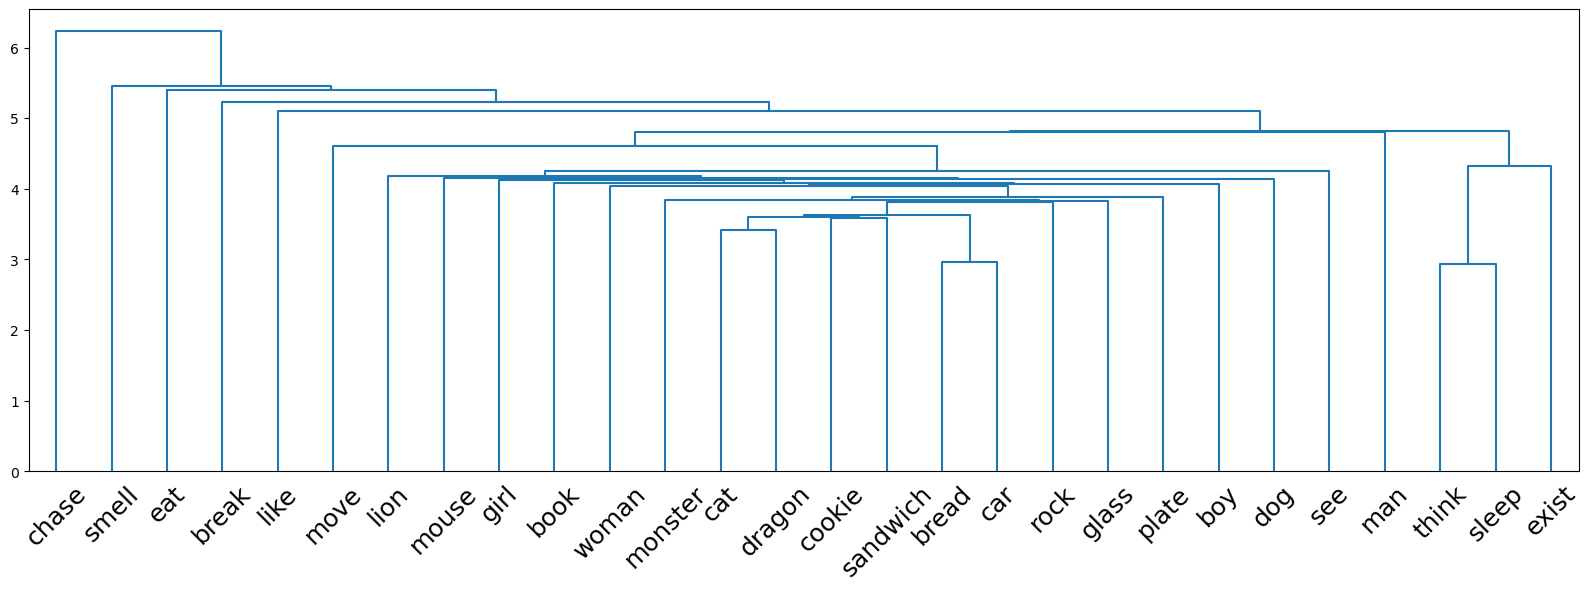

In [20]:
sm1, linked1 = plot_dendo(rnn.get_embeddings(), unique_tokens)

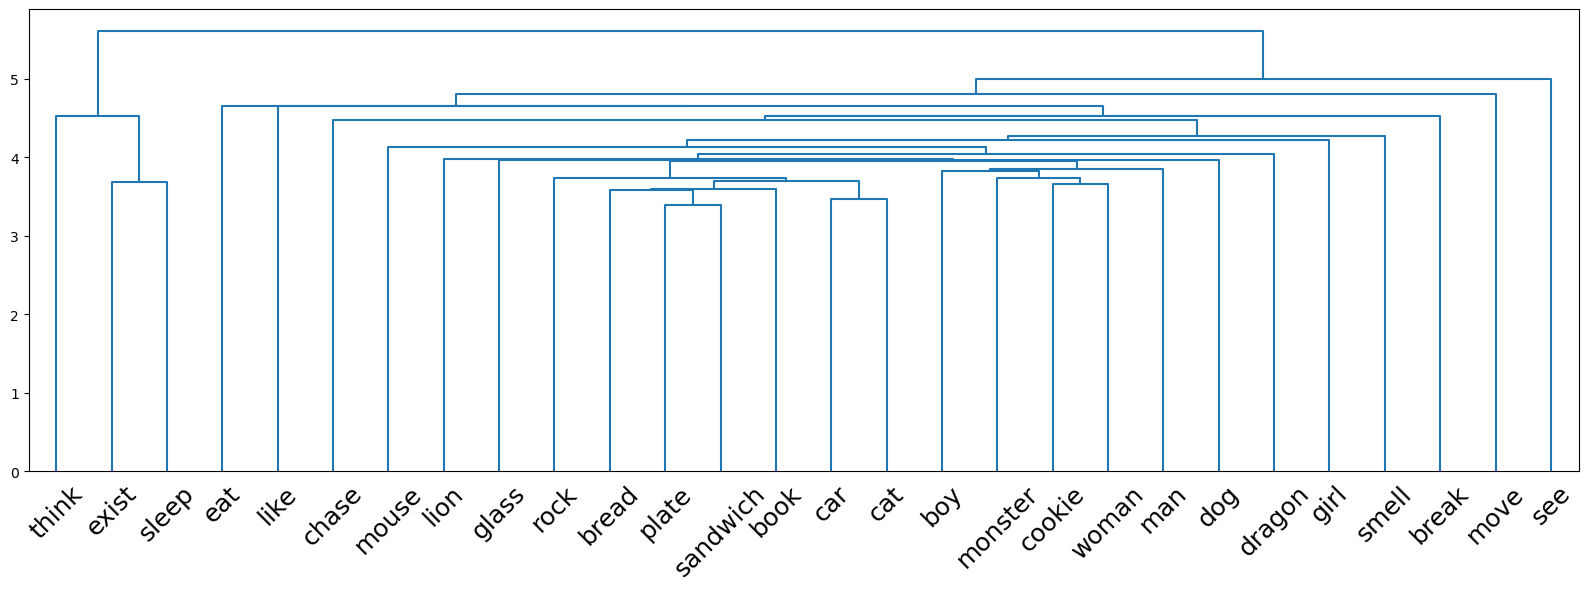

In [21]:
sm2, linked2 = plot_dendo(lstm.get_embeddings(), unique_tokens)

## 3.2 BERT (sm3)

In [10]:
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

inputs = tokenizer(unique_tokens, padding=True, truncation=True, return_tensors="pt")

inputs = {key: value.to(device) for key, value in inputs.items()}

with torch.no_grad():
    outputs = bert_model(**inputs)

embeddings = outputs.last_hidden_state.mean(dim=1)

In [11]:
def plot_dendo_bert(embeddings, unique_tokens, exclude=['<SOS>', '<EOS>']):
    include = [token not in exclude for token in unique_tokens]
    filtered_tokens = np.array(unique_tokens)[include]
    filtered_embeddings = embeddings[include]
    
    reduced_embeddings = filtered_embeddings.cpu().numpy()

    # distance matrix
    distance_matrix = pdist(reduced_embeddings)
    square_distance_matrix = squareform(distance_matrix)

    linked = linkage(reduced_embeddings, method='ward')

    plt.figure(figsize=(20, 6))
    dendrogram(linked, labels=filtered_tokens, orientation='top', distance_sort='ascending', show_leaf_counts=True, color_threshold=0,
              leaf_font_size=18)

    plt.show()
    
    return square_distance_matrix, linked

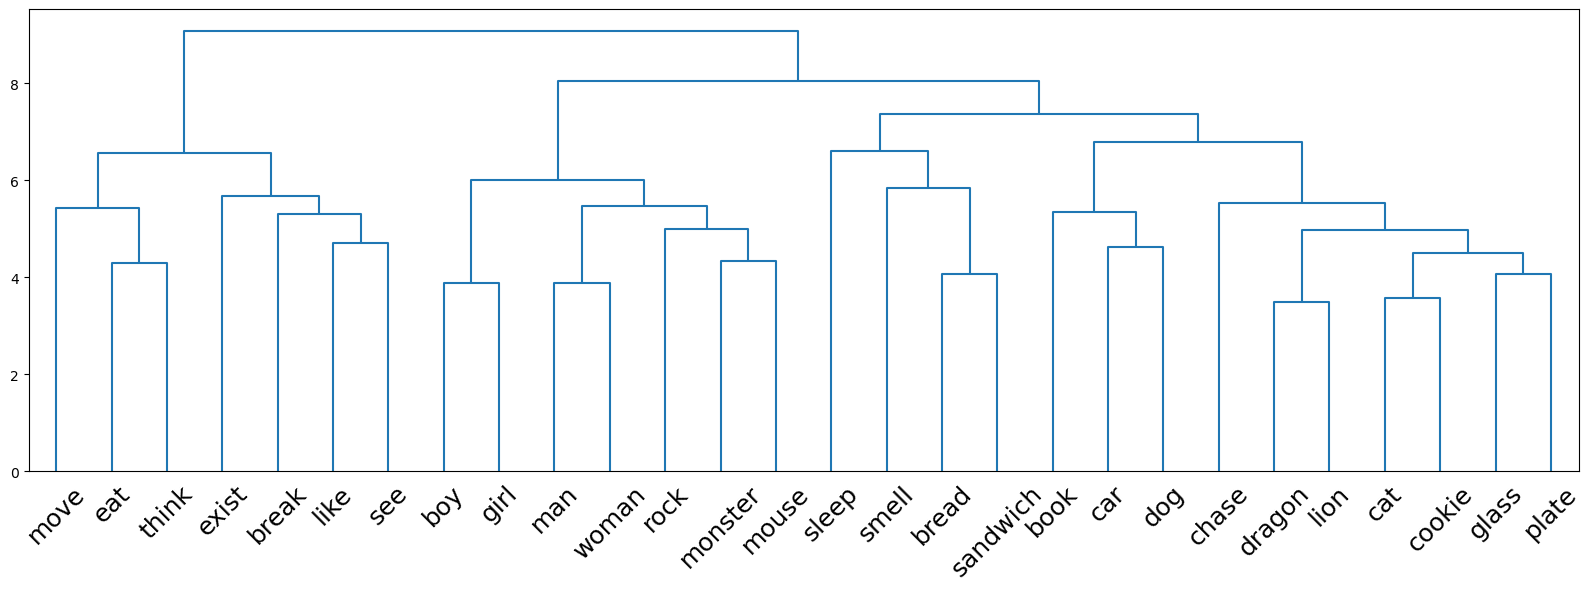

In [12]:
sm3, linked3 = plot_dendo_bert(embeddings, unique_tokens)

## 3.3 GPT-2 (sm4)

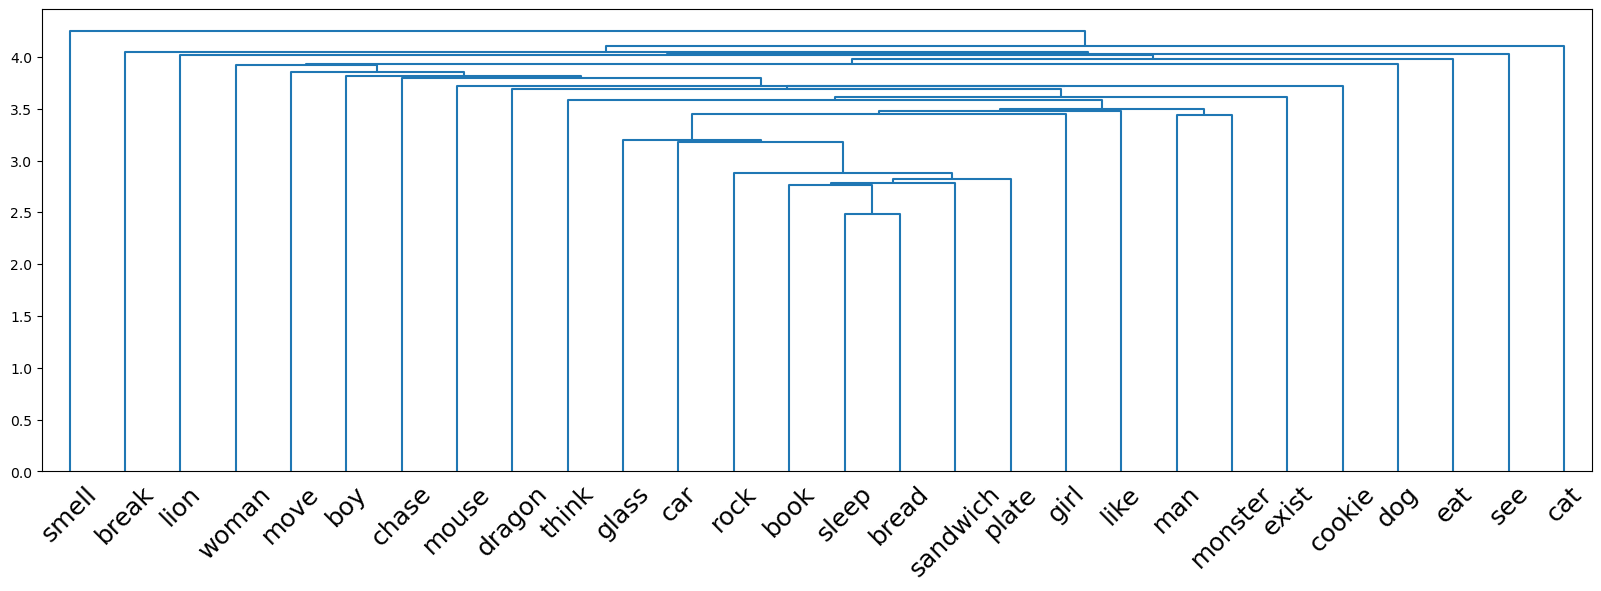

In [25]:
sm4, linked4 = plot_dendo(gpt2.get_embeddings(), unique_tokens)

## 3.4 Compare distance matrix

In [ ]:
# sm1-RNN, sm2-LSTM, sm3-BERT, sm4-GPT2

In [43]:
mse_rnn_lstm = np.mean(np.square(sm1 - sm2))
mse_rnn_bert = np.mean(np.square(sm1 - sm3))
mse_rnn_gpt2 = np.mean(np.square(sm1 - sm4))
mse_lstm_bert = np.mean(np.square(sm2 - sm3))
mse_lstm_gpt2 = np.mean(np.square(sm2 - sm4))
mse_bert_gpt2 = np.mean(np.square(sm3 - sm4))

print(f"RNN and LSTM: {mse_rnn_lstm:}")
print(f"RNN and BERT: {mse_rnn_bert:}")
print(f"RNN and GPT-2: {mse_rnn_gpt2:}")
print(f"LSTM and BERT: {mse_lstm_bert:}")
print(f"LSTM and GPT-2: {mse_lstm_gpt2:}")
print(f"BERT and GPT-2: {mse_bert_gpt2:}")

RNN and LSTM: 1.3013536291624743
RNN and BERT: 2.12378592634906
RNN and GPT-2: 4.2607029926031945
LSTM and BERT: 0.8613669602051816
LSTM and GPT-2: 2.0449983559111344
BERT and GPT-2: 1.7787843786012898


In [ ]:
# sm1, linked1 = plot_dendo(rnn.get_embeddings(), unique_tokens)

In [ ]:
# plt.imshow(sm)

In [ ]:
# sm2, linked2 = plot_dendo(lstm.get_embeddings(), unique_tokens)

In [ ]:
# np.mean(np.square(sm1 - sm2))

In [ ]:
# this plot isn't helpful
# plt.imshow(sm - sm2)
# plt.colorbar()
# plt.show() 

# 4. Text generation

## 4.1 RNN & LSTM

In [39]:
def generate(model, maxlen=4):
    model.eval()
    
    input_seq = torch.tensor(1) # the first input tensor '<sos>'
    hidden = model.initHidden()
    
    tokens = [1]
    
    for _ in range(maxlen):
        output, hidden = model(input_seq, hidden)  # Pass hidden state
        
        # Get possibilities
        output_dist = torch.softmax(output, dim=0)
        categorical = torch.distributions.categorical.Categorical(output_dist)
        
        # Sample the next token
        next_token = categorical.sample().item()
        tokens.append(next_token)
        
        # Prepare the next input
        input_seq = torch.tensor(next_token)
        
    generated_sentence =  ' '.join([word for token in tokens for word, key in token_to_index.items() if key == token])
    print(generated_sentence)

In [40]:
for i in range(10):
    generate(rnn)

<SOS> girl smell glass <EOS>
<SOS> man like dog <EOS>
<SOS> girl eat sandwich <EOS>
<SOS> monster move bread <EOS>
<SOS> woman break rock <EOS>
<SOS> monster break plate <EOS>
<SOS> monster smell sandwich <EOS>
<SOS> dog sleep <EOS> <EOS>
<SOS> monster think <EOS> <EOS>
<SOS> mouse move rock <EOS>


In [41]:
for i in range(10):
    generate(lstm)

<SOS> book sleep sleep sleep
<SOS> man cat move move
<SOS> girl glass sleep like
<SOS> glass bread woman rock
<SOS> dog rock woman glass
<SOS> see car plate chase
<SOS> <SOS> book chase exist
<SOS> dragon lion think mouse
<SOS> eat dog book plate
<SOS> <EOS> girl monster exist


## 4.2 BERT

In [36]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
b_model = BertModel.from_pretrained('bert-base-uncased').to(device)


def generate(model, tokenizer, maxlen=10, start_token='<SOS>'):

    model.eval()

    input_ids = tokenizer.encode(start_token, return_tensors='pt').to(device)
    
    for _ in range(maxlen):
        with torch.no_grad():
            outputs = model(input_ids)
            last_hidden_state = outputs.last_hidden_state

        logits = last_hidden_state[:, -1, :]
        probabilities = F.softmax(logits, dim=-1)

        categorical = Categorical(probabilities)
        next_token = categorical.sample().item()

        input_ids = torch.cat([input_ids, torch.tensor([[next_token]]).to(device)], dim=1)

    generated_sentence = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    return generated_sentence

for i in range(10):
    sentence = generate(b_model, tokenizer, maxlen=10, start_token="<SOS>") 
    print(f"Generated sentence {i+1}: {sentence}")

Generated sentence 1: < sos > [unused85] [unused570] [unused686] [unused541] [unused491] [unused342] [unused114] [unused740] [unused732] [unused206]
Generated sentence 2: < sos > [unused688] [unused724] [unused38] [unused343] [unused331] [unused109] [unused652] [unused477] [unused741] [unused375]
Generated sentence 3: < sos > [unused38] [unused468] [unused713] [unused47] [unused349] [unused154] [unused574] [unused308] [unused234]
Generated sentence 4: < sos > [unused533] [unused329] [unused683] [unused111] [unused434] [unused117] [unused261] [unused673] [unused225] [unused524]
Generated sentence 5: < sos > [unused370] [unused265] [unused208] [unused617] [unused523] [unused749] [unused666] [unused621] [unused718] [unused576]
Generated sentence 6: < sos > [unused571] [unused74] [unused363] [unused534] [unused538] [unused257] [unused545] [unused199] [unused39] [unused406]
Generated sentence 7: < sos > [unused548] [unused504] [unused363] [unused308] [unused478] [unused696] [unused341] [unu

In [48]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

text = "BERT is a [MASK] model for NLP."

input_ids = tokenizer.encode(text, return_tensors="pt")

with torch.no_grad():
    outputs = model(input_ids)
    predictions = outputs.logits

mask_token_index = torch.where(input_ids == tokenizer.mask_token_id)[1]
predicted_token_id = predictions[0, mask_token_index].argmax(axis=-1)

predicted_token = tokenizer.decode(predicted_token_id)

print(f"Predicted word: {predicted_token}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Predicted word: business


## 4.3 GPT-2

In [42]:
for i in range(10):
    generate(gpt2)

<SOS> like break monster monster
<SOS> eat dog like think
<SOS> move see <SOS> dragon
<SOS> glass smell think girl
<SOS> exist see sleep chase
<SOS> dog chase glass sleep
<SOS> glass girl plate exist
<SOS> dog sandwich sandwich break
<SOS> boy monster cat dragon
<SOS> car man plate dog
